In [13]:
import pandas as pd
from glob import glob
from os import path, listdir, mkdir
from matplotlib import rc
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from PIL import Image

In [ ]:
def hclust(aai_file, metadata):
    """
    aai_file: CompareM outputfile
    metadata = pd.DataFrame
    """
    df = pd.read_csv(aai_file, sep="\t")
    df["#Genome A"] = df["#Genome A"].str.split("_genomic", expand=True).iloc[:, 0].str[:15]
    df["Genome B"] = df["Genome B"].str.split("_genomic", expand=True).iloc[:, 0].str[:15]
    df_ = df.rename(columns={"#Genome A": "Genome B", "Genome B": "#Genome A"})
    df_t = pd.concat([df, df_], sort=True)
    
    table = pd.pivot_table(
    df_t,
    values="Mean AAI",
    index = ("#Genome A"),
    columns = ("Genome B")
)
    table = table.fillna(value=99.99)
    qc_filter = [i for i in metadata["assembly_accession"] if i in table.columns]
    table = table[qc_filter].loc[qc_filter]
    renaming_dict = pd.Series(metadata["label"].values,
                              index=metadata["assembly_accession"]).to_dict()
    
    table.rename(columns = renaming_dict, index=renaming_dict, inplace=True)
    
    X = abs(table - 99.99)
    X = squareform(X)
    Z = linkage(X,
            method="complete",
            metric="cityblock",
            optimal_ordering=True
           )
    
    return (Z, table.columns)


def augmented_dendrogram(*args, **kwargs):

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > 1.5:
                plt.plot(x, y, 'ro')
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

    return ddata


def plot_hclust(Z, columns, figsize=False, save=False, rotate=True):
    if figsize:
        fig = plt.figure(figsize=figsize)
    
    dn = augmented_dendrogram(Z,
                              labels = columns,
                              leaf_rotation=-90,
                              color_threshold=30,
                              leaf_font_size=9,
                             )
    
    if save:
        plt.savefig(save, dpi=1200, bbox_inches="tight")
    else:
        rotate=False
        
    if rotate:
        im = Image.open(save)
        im = im.rotate(90, expand=True)
        im.save(save)

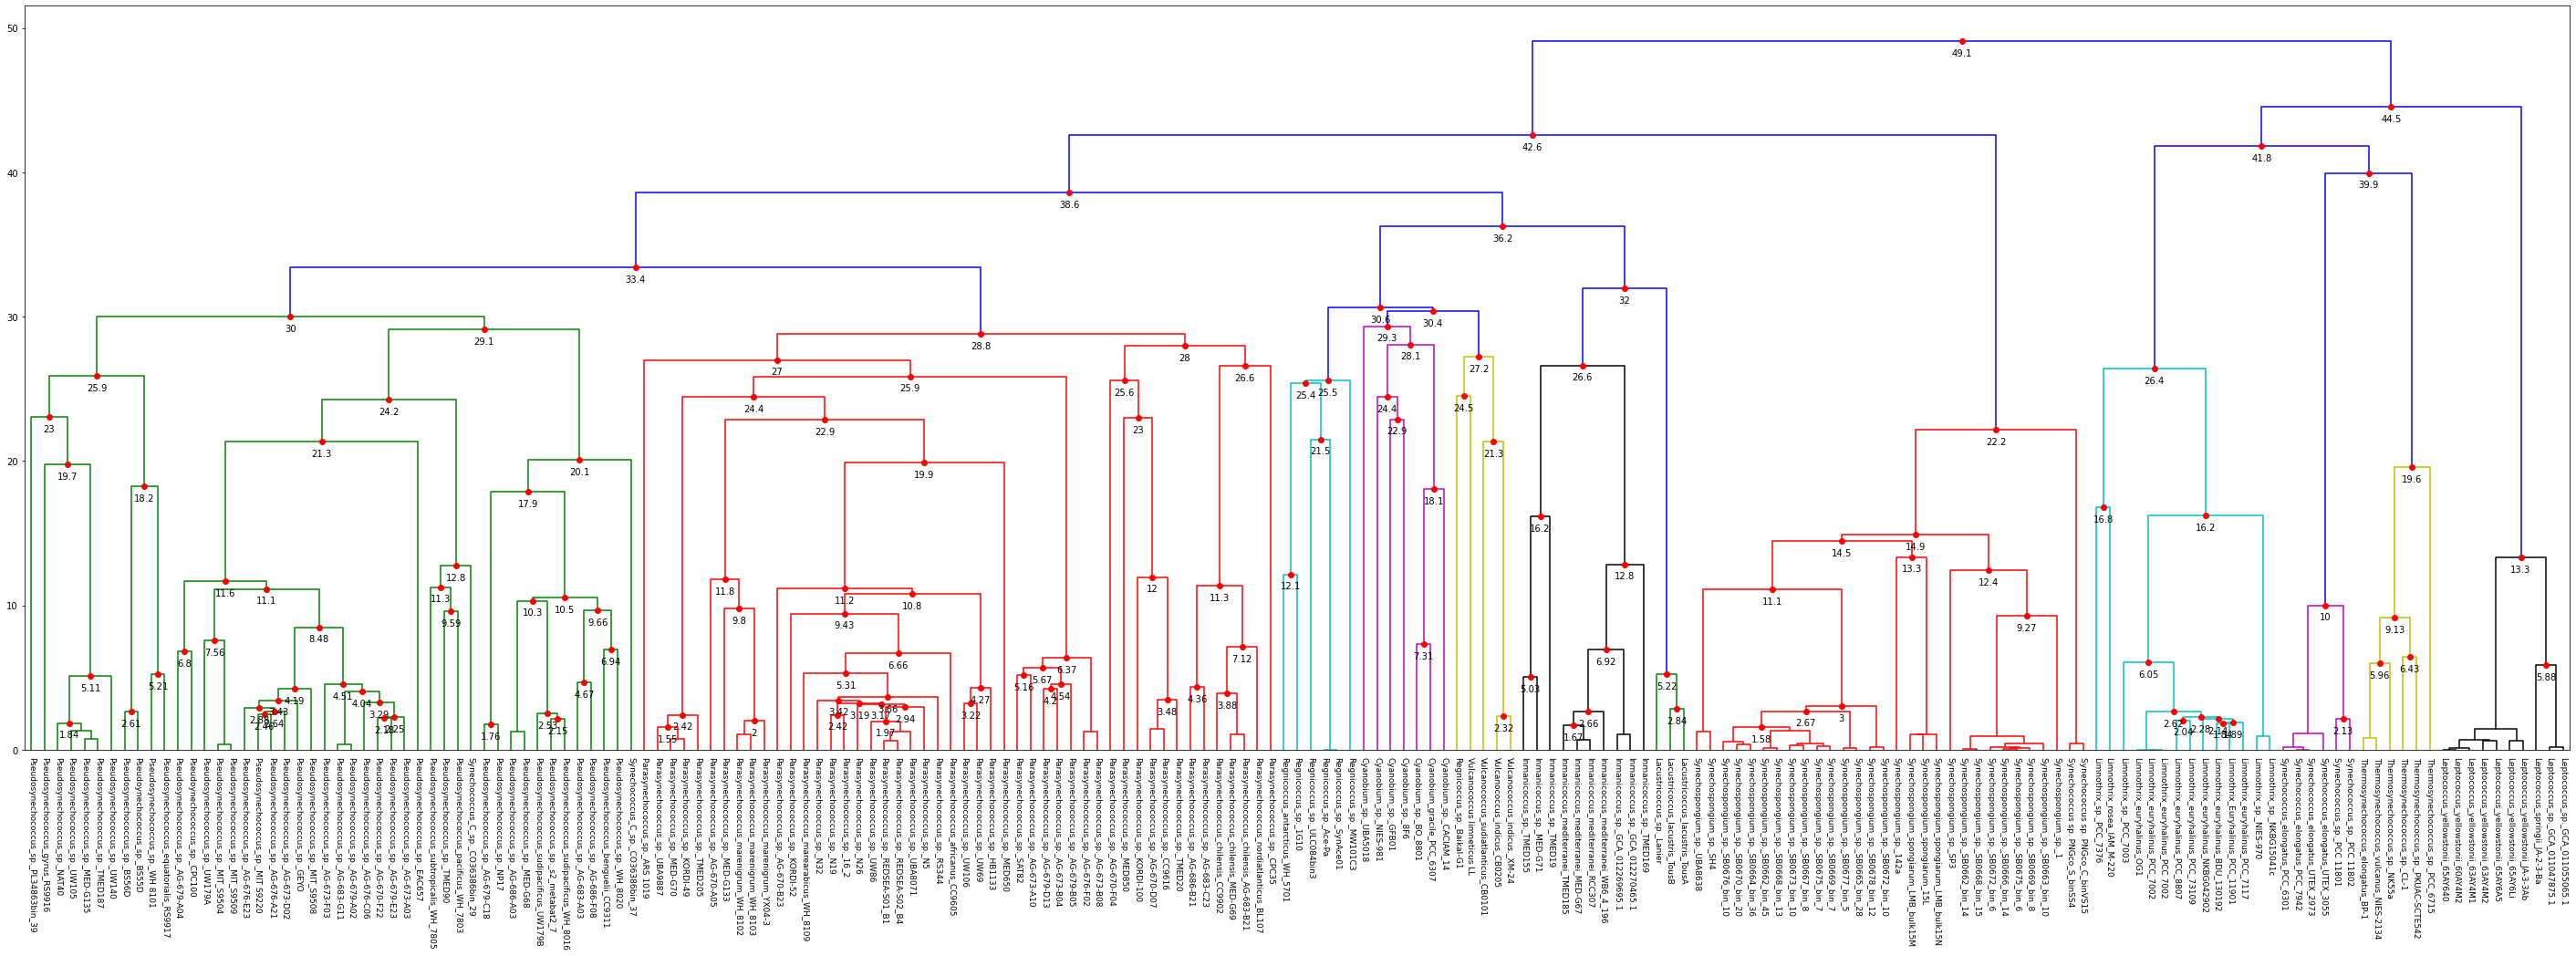

In [7]:
metadata = pd.read_csv("../data/metadata.csv")
metadata['no_genus'] = metadata.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", 
                    metadata=metadata[(metadata['is_synecho']) & (metadata['quality_filter']) & (metadata['no_genus'] > 1)])
plot_hclust(Z, columns, figsize=(50,15))

In [16]:
def parse_label(row):

    split = row.replace(" ", "_").split("_")
    genus = split[0]
    species = split[1]
    strain = " ".join(split[2:])

    strain = "\ \mathrm{" + strain + "}"
    if species == "sp.":
        species = " \mathrm{" + species + "}"
    label = f'${genus}\ {species} {strain}$'
    return label

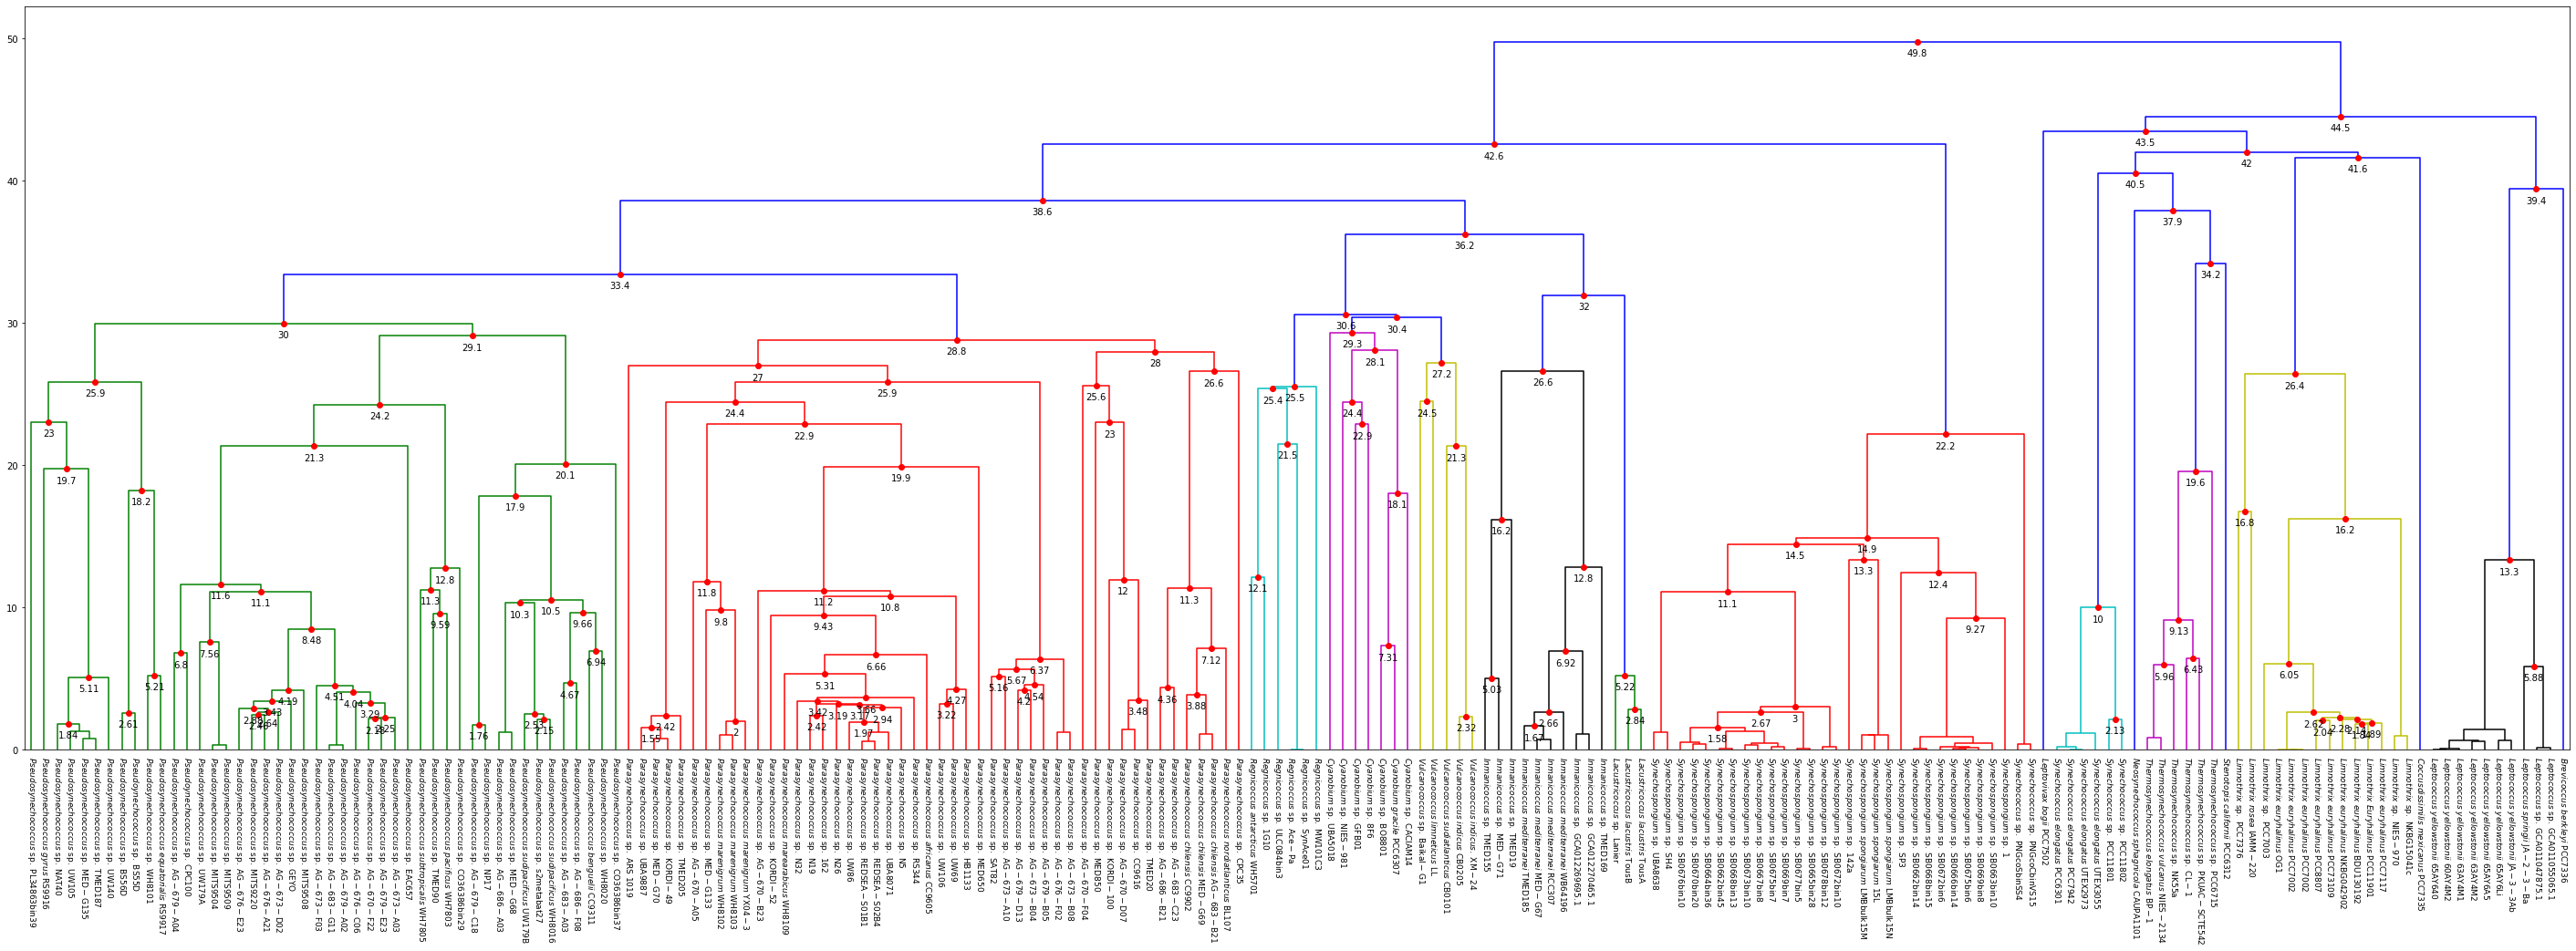

In [20]:
metadata = pd.read_csv("../data/metadata.csv")
metadata['no_genus'] = metadata.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")
metadata=metadata[(metadata['is_synecho']) & (metadata['quality_filter']) & (metadata['no_genus'] > 0)]
metadata['label'] = metadata['label'].apply(lambda row: parse_label(row))
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", metadata=metadata)
plot_hclust(Z, columns, figsize=(50,15), save="../data/plots/final/Figure_2_AAI.pdf", rotate=False)

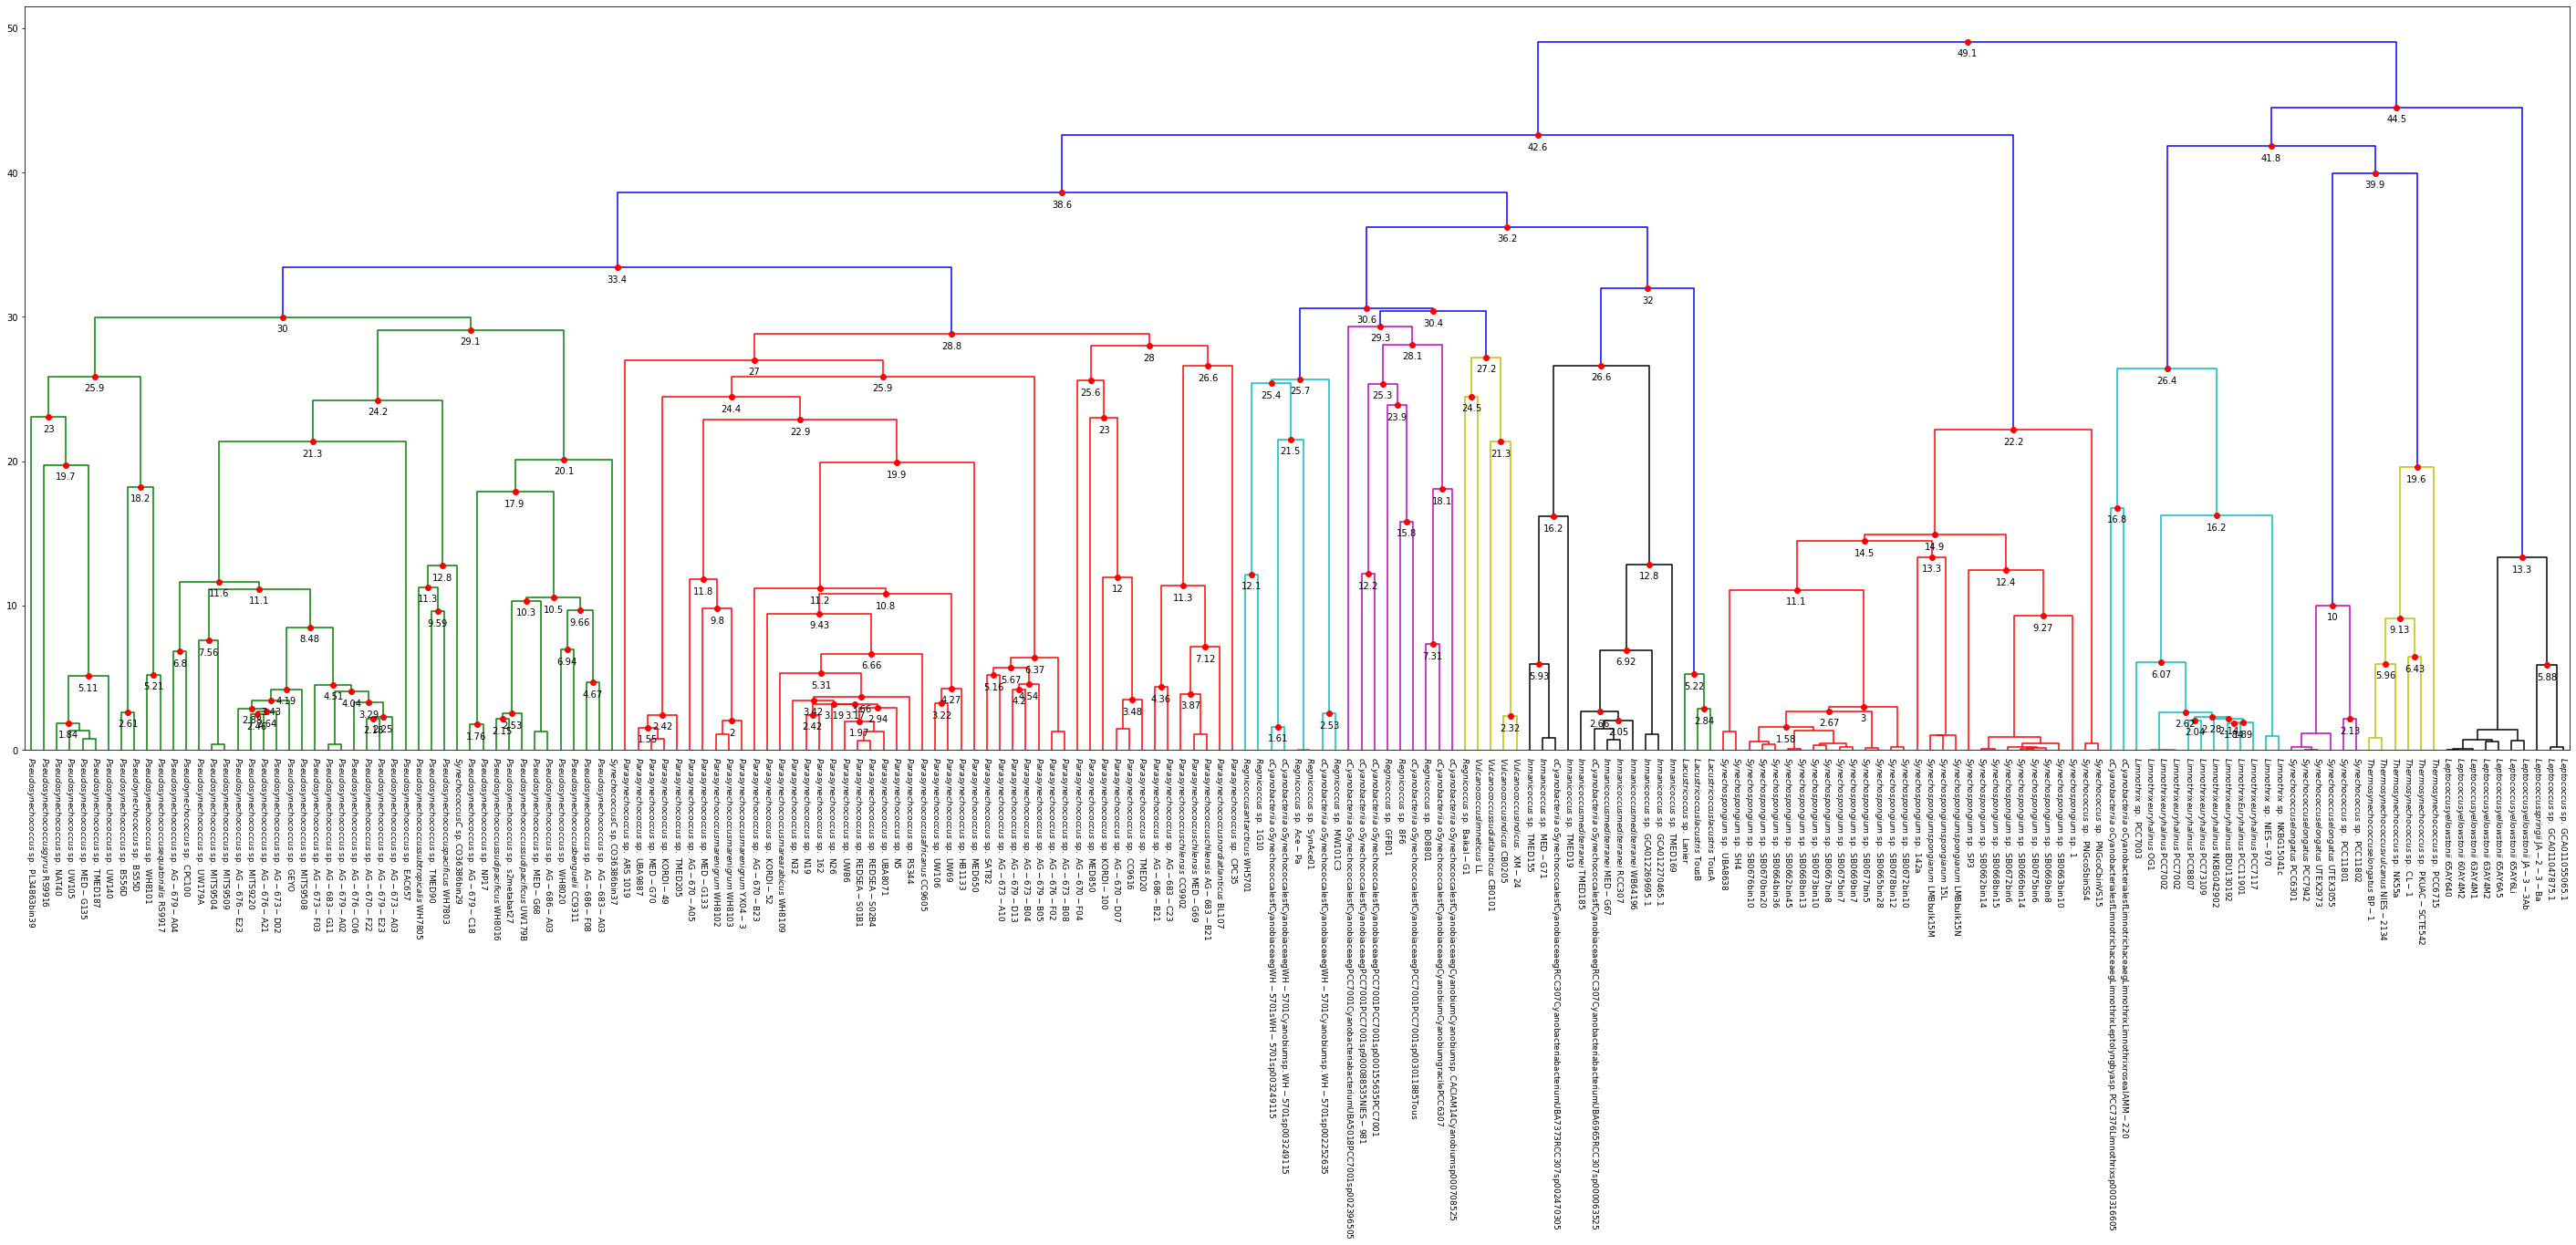

In [80]:
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", 
                    metadata=metadata[(metadata['is_synecho']) |
                                      metadata['label'].apply(lambda s: any(i in s for i in ("SS2", "SS35", "SS52", "SS51", "CCMP1375"))) &
                                      (metadata['quality_filter']) &
                                      (metadata['label'].apply(lambda s: any([i in s for i in [
                        "Parasynechococcus", "Pseudosynechococcus", "Vulcanococcus", "Regnicoccus", "Lacustricoccus", "Inmanicoccus", "Synechospongium", "Prochlorococcus"]])))])
plot_hclust(Z, columns, figsize=(50,15), save="../data/plots/aai/aai_cyanobiaceae_and_prochlorococcus.png")

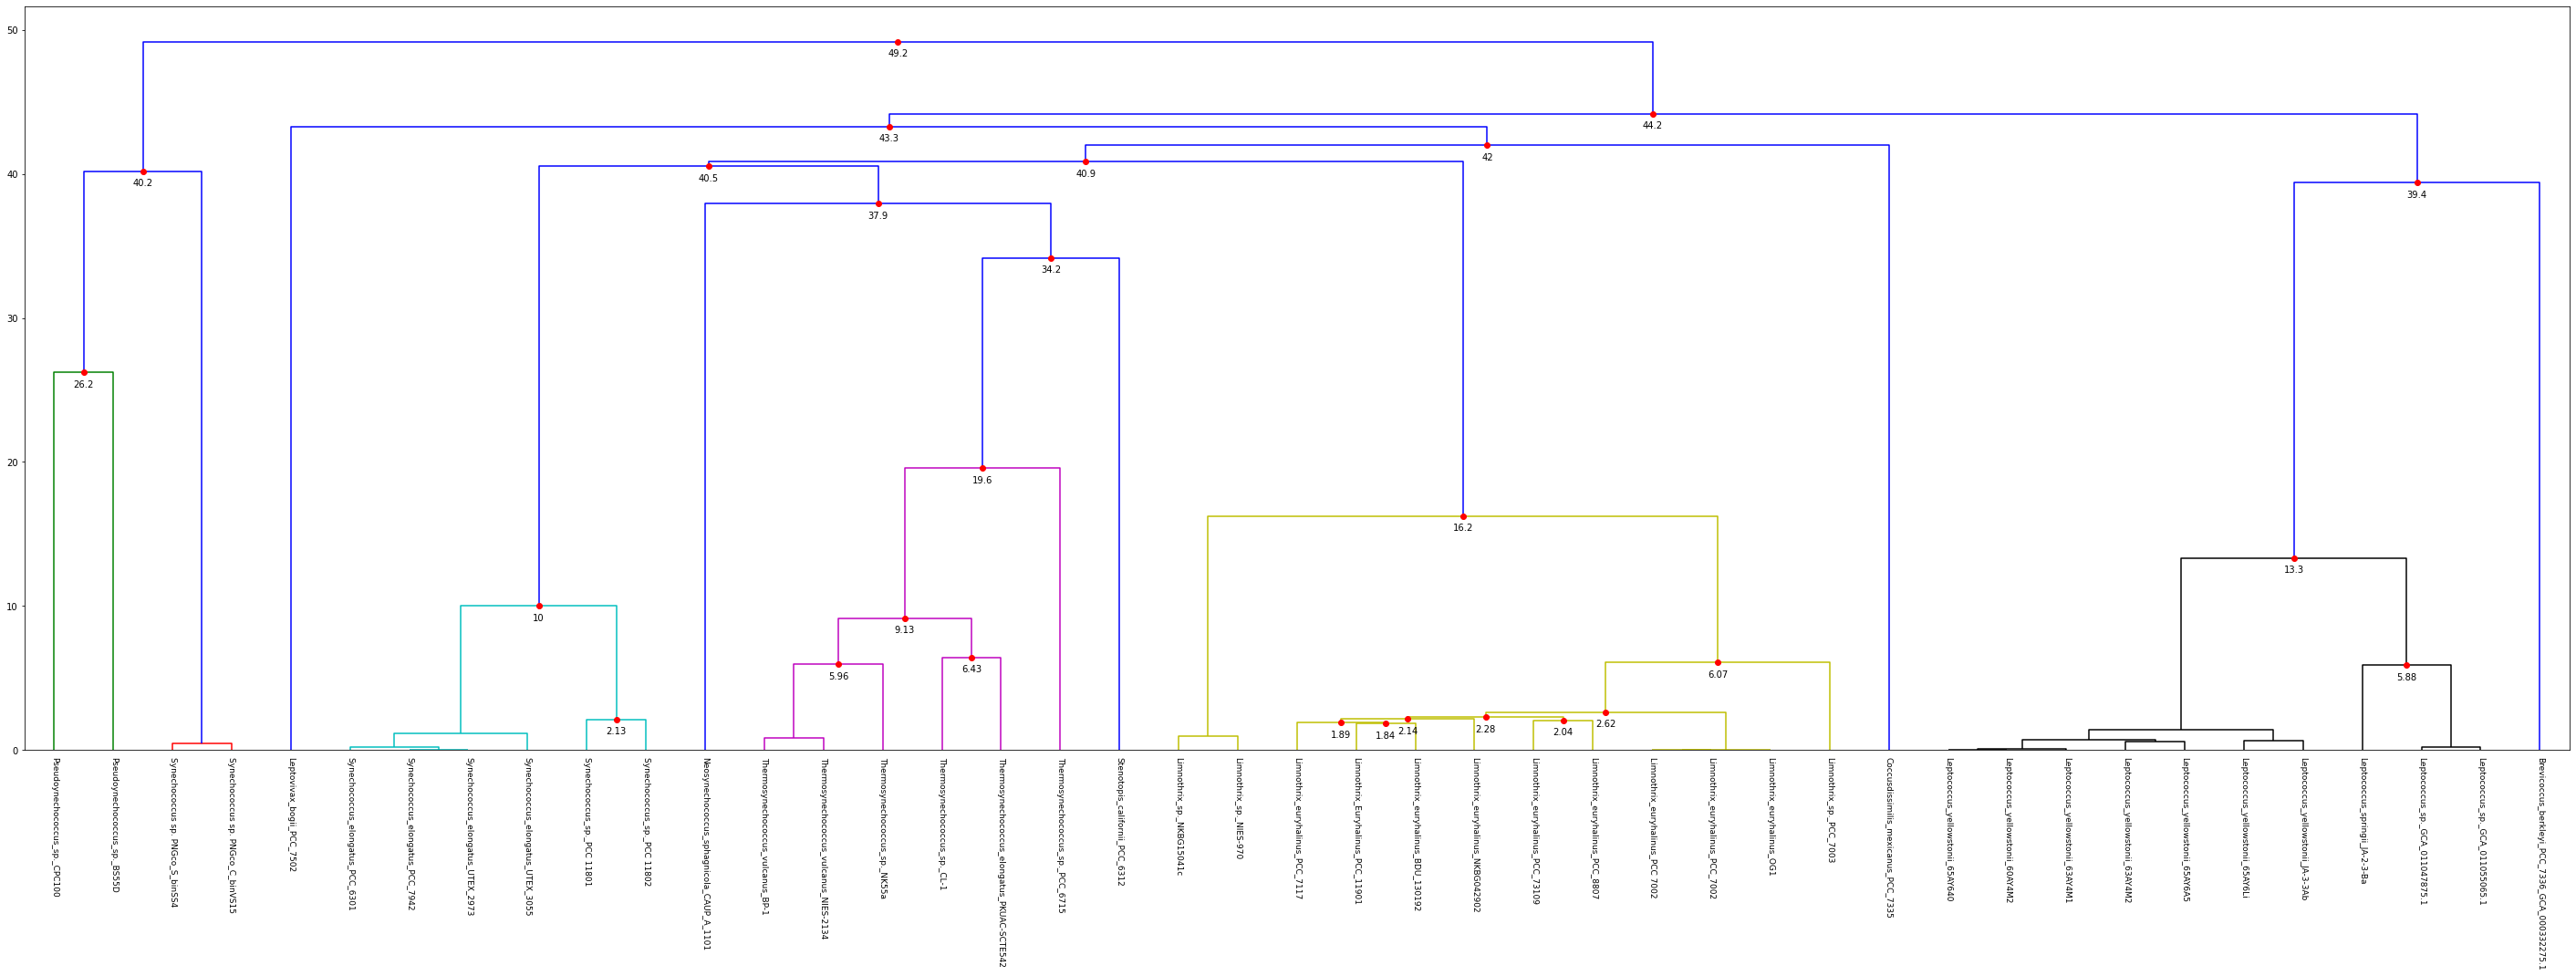

In [28]:
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", 
                    metadata=metadata[(metadata['is_synecho']) & (metadata['quality_filter']) & ~(metadata['label'].apply(lambda s: any([i in s for i in [
                        "Parasynechococcus", "Pseudosynechococcus", "Vulcanococcus", "Regnicoccus", "Lacustricoccus", "Inmanicoccus", "Synechospongium"]])))])
plot_hclust(Z, columns, figsize=(50,15), save="../data/plots/aai/aai_other_cyano.png")

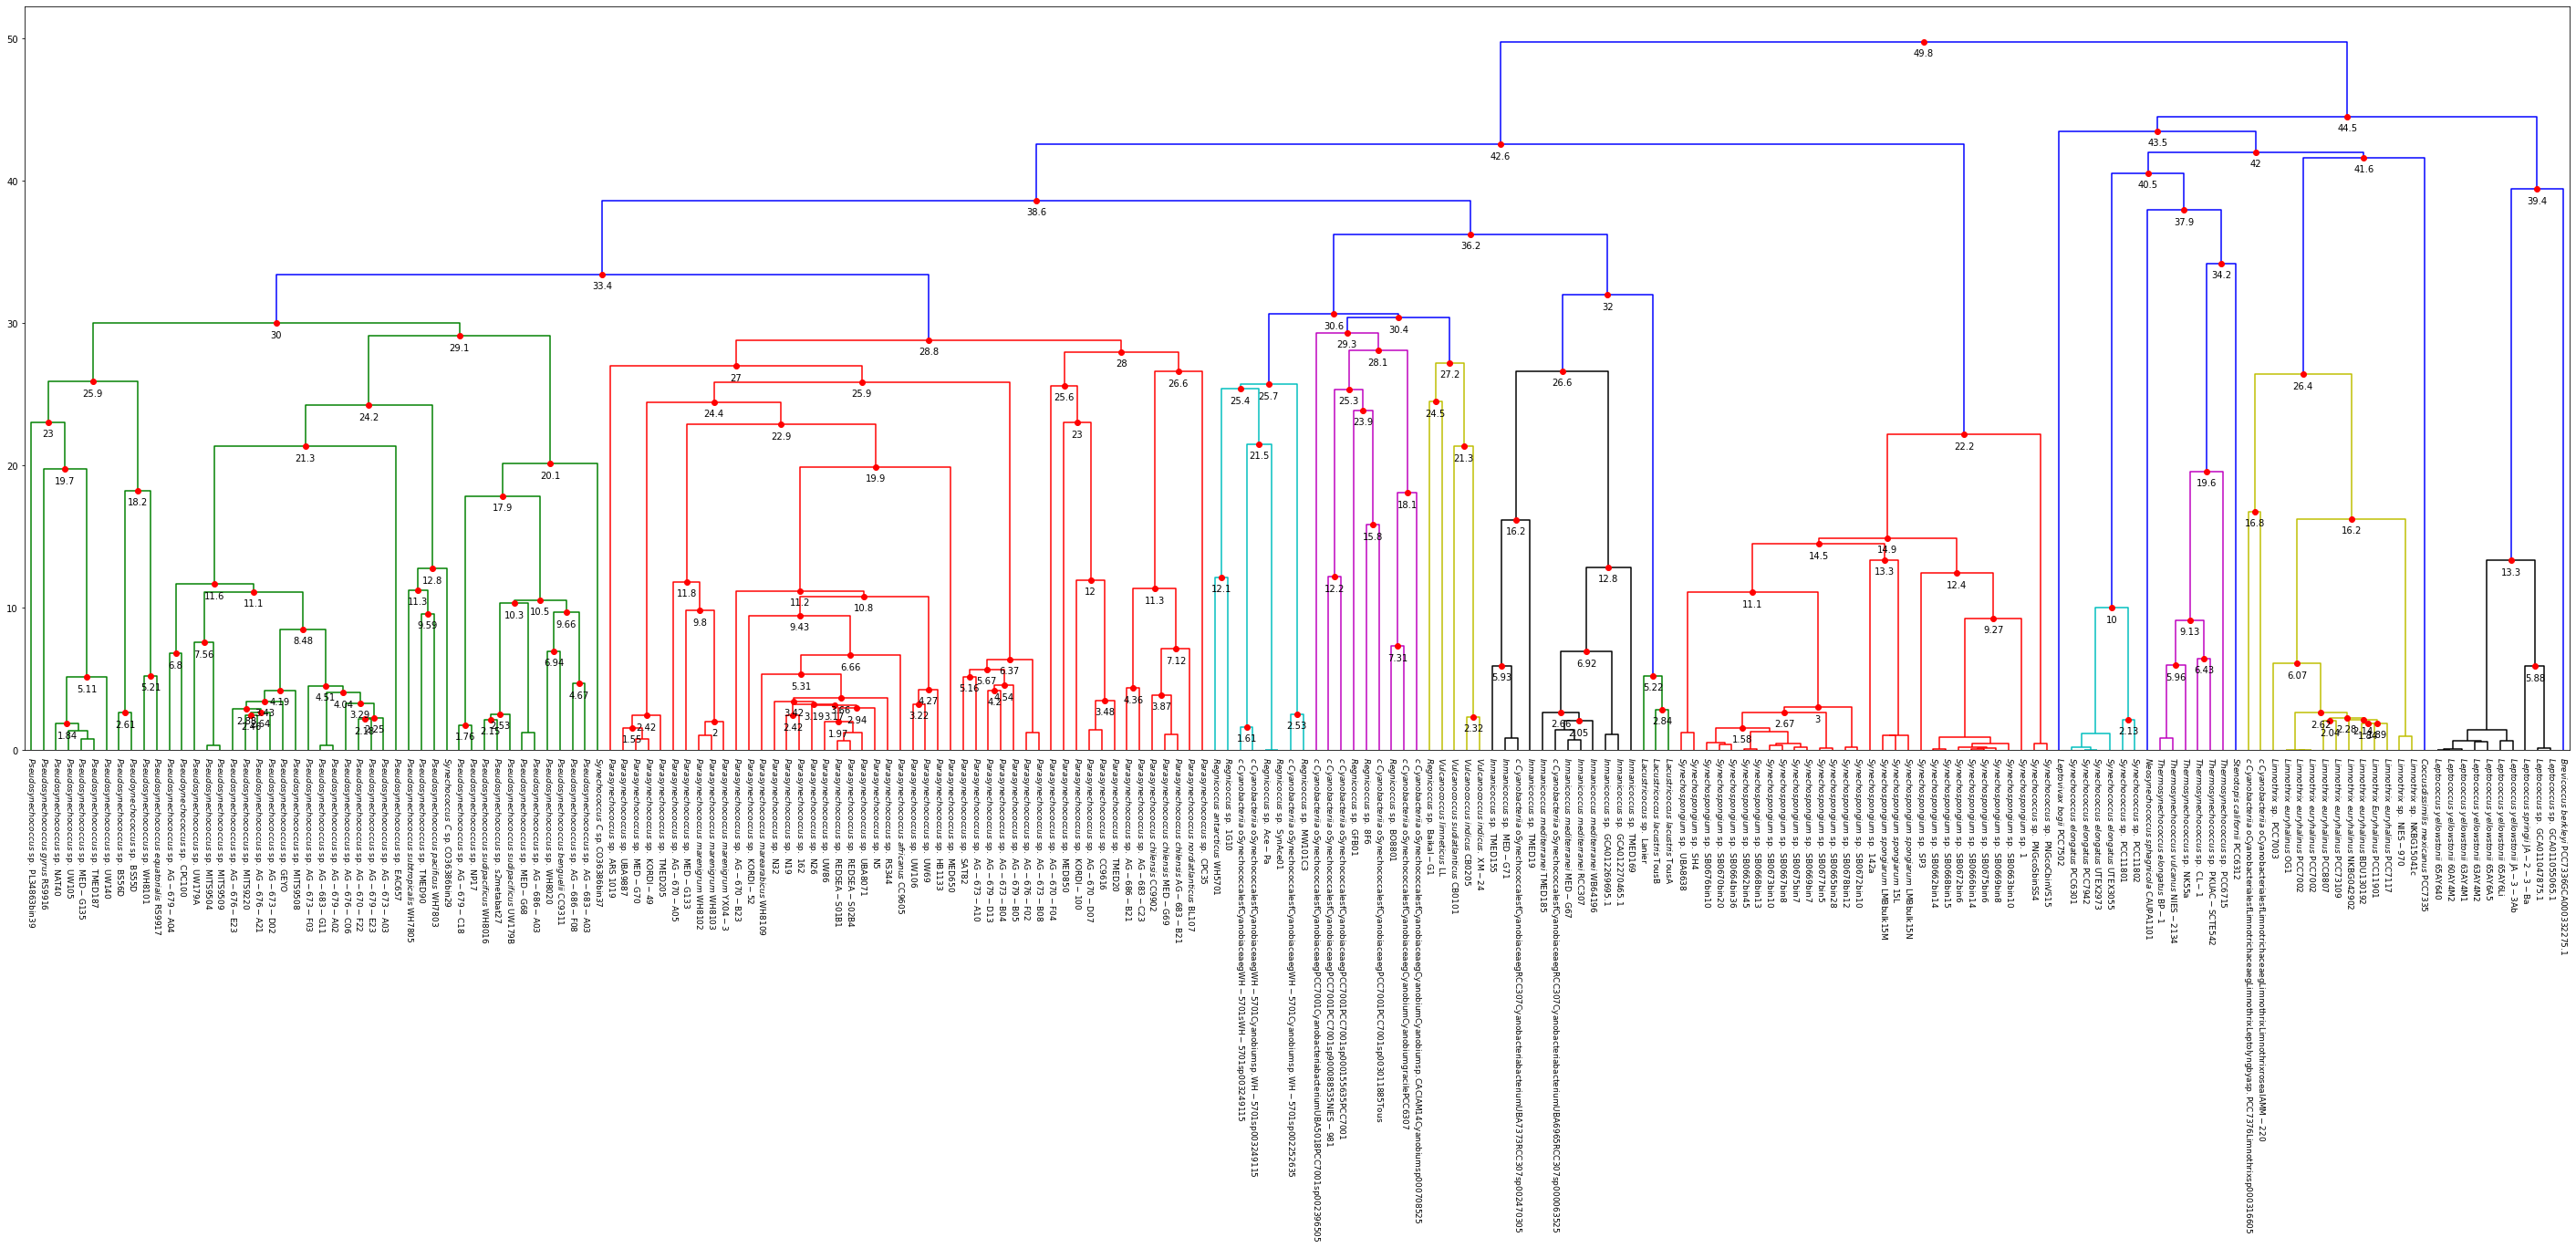

In [84]:
metadata = pd.read_csv("../data/metadata.csv")
metadata['no_genus'] = metadata.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")
metadata['label'] = metadata['label'].apply(lambda row: parse_label(row))
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", 
                    metadata=metadata[(metadata['is_synecho']) & (metadata['quality_filter']) & (metadata['no_genus'] > 0) | (metadata['label'].str.contains("Brevicoccus"))])
plot_hclust(Z, columns, figsize=(50,15), save="../data/plots/aai/synechos_filtered.png")